In [ ]:
!pip install pandas numpy scikit-learn matplotlib

In [ ]:

# Конфиг - немного сделаем настроек и обозначим типы активностей датасета
RANDOM_STATE = 42
TEST_SIZE = 0.2

ACTIVITIES = {
    1: 'WALKING',
    2: 'WALKING_UPSTAIRS',
    3: 'WALKING_DOWNSTAIRS',
    4: 'SITTING',
    5: 'STANDING',
    6: 'LAYING'
}

#Загрузка данных

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from config import *
import os
import urllib.request
import zipfile

class HARDataLoader:
    def __init__(self):
        self.dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
        self.dataset_path = "UCI_HAR_Dataset"
        self.zip_path = "HAR_Dataset.zip"
#Загрузка и распаковка датасета
    def download_dataset(self):
        if not os.path.exists(self.dataset_path):
            try:
                # Скачиваем датасет
                urllib.request.urlretrieve(self.dataset_url, self.zip_path)
                print("Датасет загружен.")

                # Распаковываем
                with zipfile.ZipFile(self.zip_path, 'r') as zip_ref:
                    zip_ref.extractall(".")
                print("Датасет распакован")

                # Удаляем zip файл
                os.remove(self.zip_path)
                print("Временные файлы удалены")

            except Exception as e:
                print(f" Ошибка загрузки и/или распаковки датасета: {e}")
                raise
        else:
            print(" Датасет уже загружен.")

#Подгружаем датасет HAR
    def load_har_data(self):
        print("Загрузка  датасета Human Activity Recognition Using Smartphones.")

        # Проверяем наличие, если нет - скачиваем
        self.download_dataset()

        # Загружаем тренировочные данные
        print("Загружаем тренировочные данные")
        X_train = pd.read_csv(
            f'{self.dataset_path}/train/X_train.txt',
            sep=r'\s+',
            header=None
        )
        y_train = pd.read_csv(
            f'{self.dataset_path}/train/y_train.txt',
            header=None
        )

        # Загружаем тестовые данные
        print("Загружаем тестовые данные.")
        X_test = pd.read_csv(
            f'{self.dataset_path}/test/X_test.txt',
            sep=r'\s+',
            header=None
        )
        y_test = pd.read_csv(
            f'{self.dataset_path}/test/y_test.txt',
            header=None
        )

        # Загружаем названия признаков
        print("Загружаем названия признаков - метаданные.")
        features = pd.read_csv(
            f'{self.dataset_path}/features.txt',
            sep=r'\s+',
            header=None,
            names=['index', 'feature_name']
        )

        # Загружаем названия видов активностей
        activity_labels = pd.read_csv(
            f'{self.dataset_path}/activity_labels.txt',
            sep=r'\s+',
            header=None,
            names=['label', 'activity_name']
        )

        # Объединяем тренировочные и тестовые данные
        X = pd.concat([X_train, X_test], axis=0)
        y = pd.concat([y_train, y_test], axis=0)

        # Устанавливаем названия признаков
        X.columns = features['feature_name'].values

        # Преобразуем метки в numpy array
        y = y.values.ravel()

        print("Датасет HAR успешно загружен.")
        print(f"Размер данных: {X.shape}.")
        print(f"Количество загруженных классов: {len(activity_labels)}.")

        return X, y, activity_labels, features

#Подготавливаем данные для обучения
def prepare_data():
    loader = HARDataLoader()
    X, y, activity_labels, features = loader.load_har_data()

    # Показываем информацию о данных
    print(f"\n ИНФОРМАЦИЯ О ДАТАСЕТЕ HAR:")
    print(f" Всего образцов: {X.shape[0]}")
    print(f" Количество признаков: {X.shape[1]}")
    print(f" Распределение активностей:")
    activity_counts = pd.Series(y).value_counts().sort_index()
    for label, count in activity_counts.items():
        activity_name = ACTIVITIES.get(label, f'Unknown_{label}')
        print(f"  {activity_name}: {count} образцов")

    # Показываем первые строки
    print(f"\n Покажем первых пару строк датасета:")
    print("*******************************************************************")
    print(X.iloc[:, :8].head().round(3))

    # Показываем информацию о признаках
    print(f"\n Примеры признаков:")
    print("Первые 10 названий признаков из датасета:")
    for i, feature in enumerate(features['feature_name'].head(10)):
        print(f"  {i+1}. {feature}")

    # Разделяем на обучающую и тестовую выборку
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    # Масштабируем данные
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print ("\n")
    print(f"Обучающая выборка: {X_train_scaled.shape}")
    print(f"Тестовая выборка: {X_test_scaled.shape}")
    print(f"Данные для работы подготовлены.")

    return X_train_scaled, X_test_scaled, y_train, y_test, X

#Обучение





In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from config import *

class ModelTrainer:
    def __init__(self):
        self.models = {}
        self.results = {}
        self.detailed_metrics = {}

  # Настраиваем 6 классификаторов
    def setup_models(self):
        self.models = {
            'Градиентный бустинг': GradientBoostingClassifier(n_estimators=100, random_state=42), #20+ минут
            'AdaBoost': AdaBoostClassifier(n_estimators=100, random_state=42), #3-4 минут
            'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42), #быстро
            'K Neighbors': KNeighborsClassifier(n_neighbors=5), #быстро
            'Дерево решений': DecisionTreeClassifier(max_depth=10, random_state=42), #быстро
            'Квадратичный дискриминантный анализ': QuadraticDiscriminantAnalysis(reg_param=0.5) #быстро
        }
        print(" 6 классификаторов готовы к обучению")

    # Обучаем и оцениваем модели с подробными метриками
    def train_and_evaluate(self, X_train, X_test, y_train, y_test):

        results = []

        for name, model in self.models.items():
            print(f"\n--- {name} ---")
            print(" Идет Обучение.")
            model.fit(X_train, y_train)

            # Предсказания
            y_pred = model.predict(X_test)

            # Метрики
            accuracy = accuracy_score(y_test, y_pred)
            precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
            recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
            f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
            precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
            recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
            f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)

            # Сохраняем результаты
            results.append({
                'Модель': name,
                'Accuracy': round(accuracy, 4),
                'F1-Macro': round(f1_macro, 4),
                'F1-Weighted': round(f1_weighted, 4)
            })

            # Сохраняем подробные метрики
            self.detailed_metrics[name] = {
                'accuracy': accuracy,
                'macro_avg': {'precision': precision_macro, 'recall': recall_macro, 'f1': f1_macro},
                'weighted_avg': {'precision': precision_weighted, 'recall': recall_weighted, 'f1': f1_weighted},
                'y_pred': y_pred
            }

            # Выводим метрики
            print(f"Accuracy:          {accuracy:.4f}")
            print(f"Precision (Macro): {precision_macro:.4f}")
            print(f"Recall (Macro):    {recall_macro:.4f}")
            print(f"F1-Score (Macro):  {f1_macro:.4f}")
            print(f"F1-Score (Weighted): {f1_weighted:.4f}")

        # Сортируем по точности
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('Accuracy', ascending=False)
        self.results = results_df

        return results_df

    # Показываем сводную таблицу всех метрик"
    def show_comparison_table(self):
        print("\n")
        print(" Сводная таблица метрик для всех классификаторов")
        print("\n")

        comparison_data = []
        for name, metrics in self.detailed_metrics.items():
            comparison_data.append({
                'Модель': name,
                'Accuracy': f"{metrics['accuracy']:.4f}",
                'Precision (Macro)': f"{metrics['macro_avg']['precision']:.4f}",
                'Recall (Macro)': f"{metrics['macro_avg']['recall']:.4f}",
                'F1 (Macro)': f"{metrics['macro_avg']['f1']:.4f}",
                'F1 (Weighted)': f"{metrics['weighted_avg']['f1']:.4f}"
            })

        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))

        return comparison_df

    # Возвращаем лучшую модель
    def get_best_model(self):
        best_name = self.results.iloc[0]['Модель']
        return best_name, self.models[best_name], self.detailed_metrics[best_name]

    #Показываем детальный отчет для лучшей модели
    def show_detailed_best_model_report(self, y_test):
        best_name, best_model, best_metrics = self.get_best_model()

        print(f"\n")
        print(f" Подробный отчет по лучшей модели: {best_name}")
        print(f"\n")

        y_pred = best_metrics['y_pred']
        print(classification_report(y_test, y_pred, target_names=list(ACTIVITIES.values()), zero_division=0))

        return best_name, best_metrics

#Исполняемый модуль

***********************************************
Классификация типов активностей человека - HW4
***********************************************

 Загрузка данных:
Загрузка  датасета Human Activity Recognition Using Smartphones.
 Датасет уже загружен.
Загружаем тренировочные данные
Загружаем тестовые данные.
Загружаем названия признаков - метаданные.
Датасет HAR успешно загружен.
Размер данных: (10299, 561).
Количество загруженных классов: 6.

 ИНФОРМАЦИЯ О ДАТАСЕТЕ HAR:
 Всего образцов: 10299
 Количество признаков: 561
 Распределение активностей:
  WALKING: 1722 образцов
  WALKING_UPSTAIRS: 1544 образцов
  WALKING_DOWNSTAIRS: 1406 образцов
  SITTING: 1777 образцов
  STANDING: 1906 образцов
  LAYING: 1944 образцов

 Покажем первых пару строк датасета:
*******************************************************************
   tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  tBodyAcc-std()-X  \
0              0.289             -0.020             -0.133            -0.995   
1           

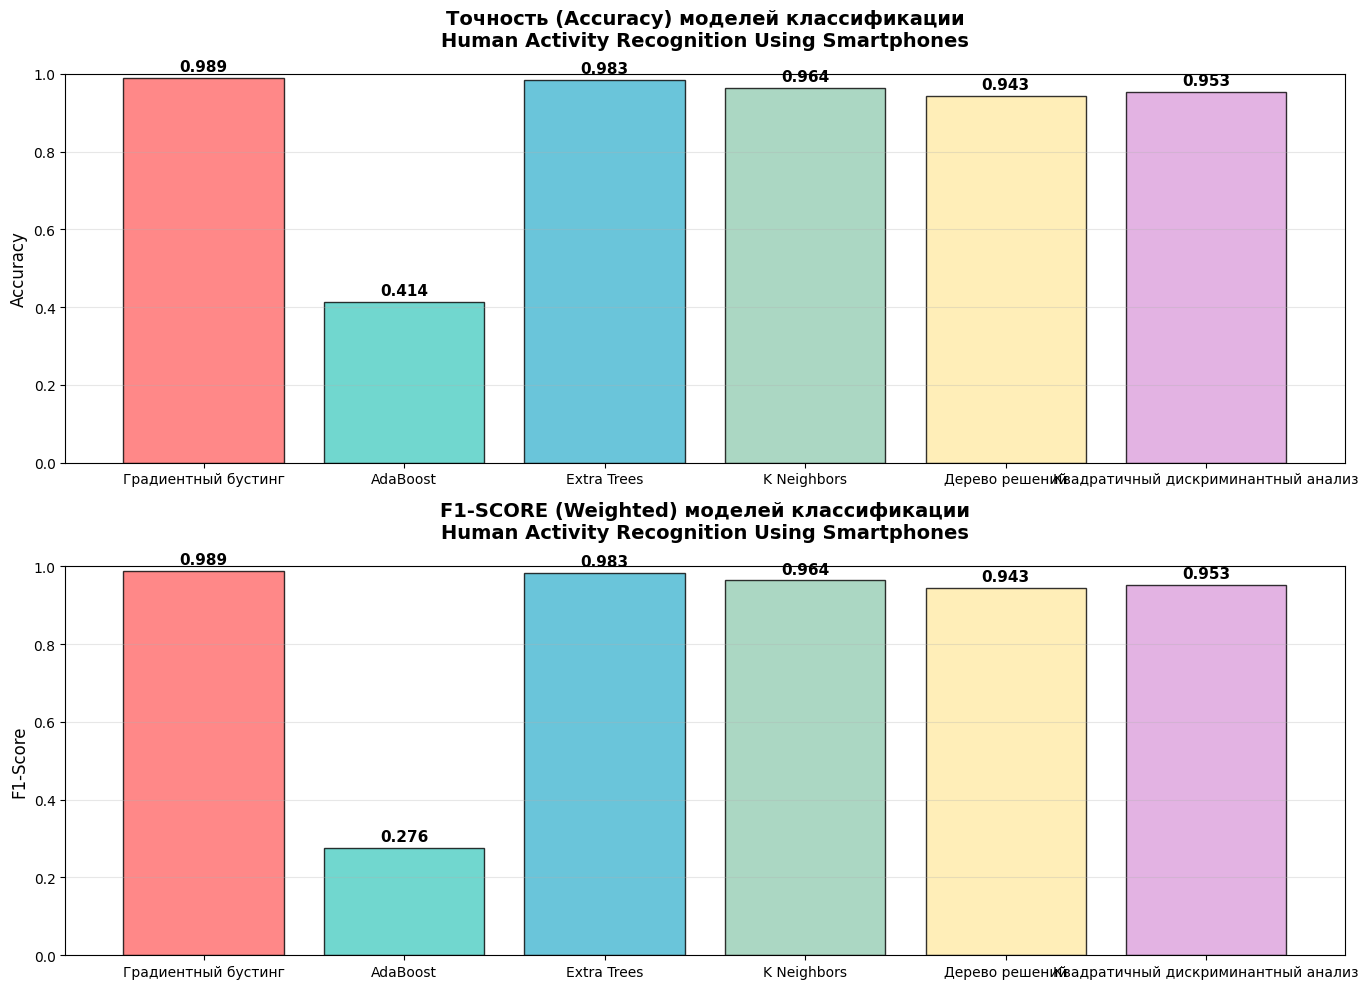


 Показываем тепловую карту:


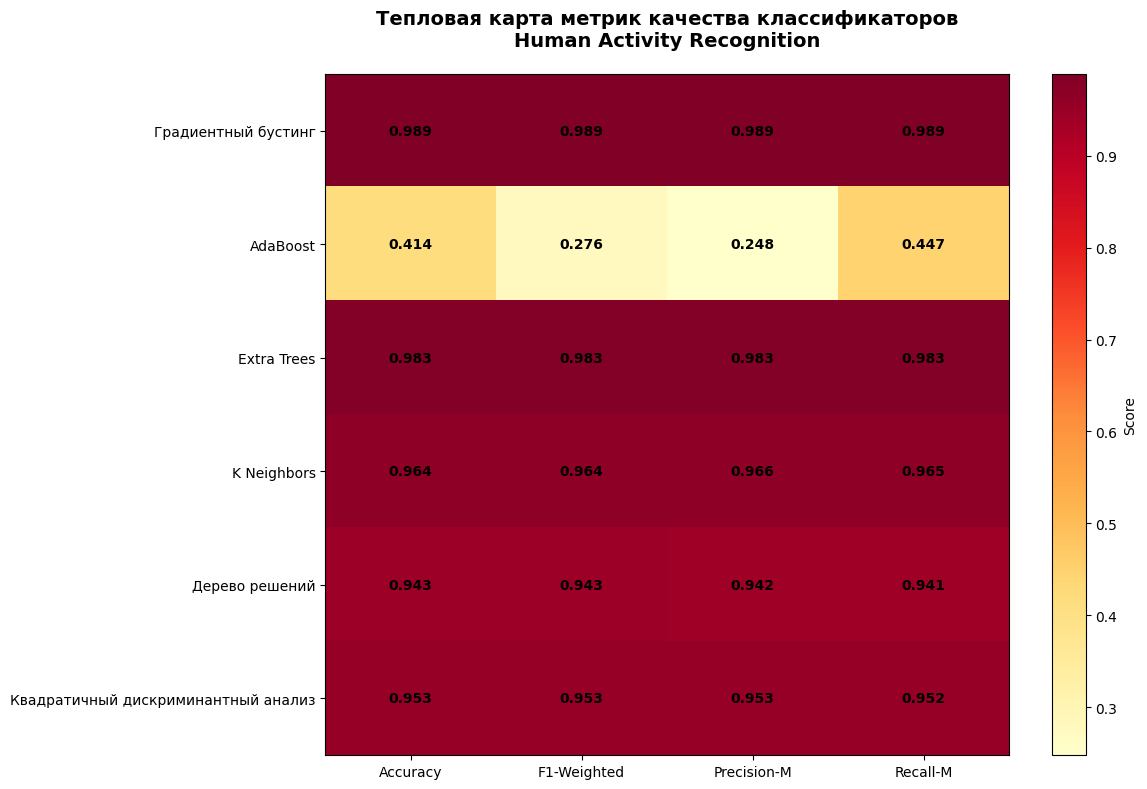

 Тепловая карта метрик показана

 Матрица ошибок лучшей модели:


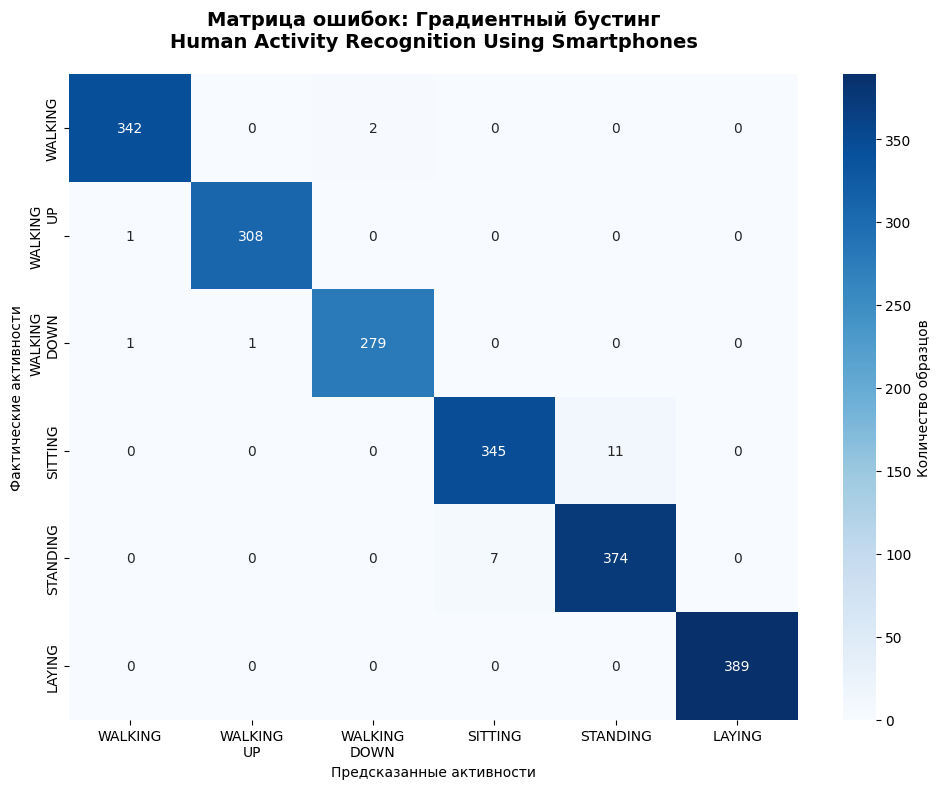


*******************************************************
 Всего протестировано классификаторов: 6
 Лучший классификатор: Градиентный бустинг
 Точность (Accuracy): 0.9888
 F1-Score (Weighted): 0.9888
 Precision (Macro): 0.9892
 Recall (Macro): 0.9891

 Вывод:
 Использован  датасет Human Activity Recognition Using Smartphones
 Ансамблевые методы показывают лучшие результаты на реальных данных - Лучшая модель градиентный бустинг
 Все метрики качества рассчитаны и проанализированы

 Выполнено успешно.


In [ ]:
#1
from data_loader import prepare_data
from model_trainer import ModelTrainer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Настраиваем отображение графиков в Jupyter (используем inline режим)
def setup_jupyter_plots():
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            get_ipython().run_line_magic('matplotlib', 'inline')
            return True
        else:
            print(" Запущено вне Jupyter.")
            return False
    except:
        print("Не удалось настроить inline режим")
        return False

# Создаем график сравнения моделей
def create_colorful_comparison_plot(detailed_metrics):
    models = list(detailed_metrics.keys())
    accuracy_values = [detailed_metrics[m]['accuracy'] for m in models]
    f1_weighted_values = [detailed_metrics[m]['weighted_avg']['f1'] for m in models]

    # Создаем фигуру
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # График точности
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD']
    bars1 = ax1.bar(models, accuracy_values, color=colors[:len(models)], alpha=0.8, edgecolor='black')
    ax1.set_title('Точность (Accuracy) моделей классификации\nHuman Activity Recognition Using Smartphones',
                 fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_ylim(0, 1.0)
    ax1.grid(True, alpha=0.3, axis='y')

    # Добавляем значения на столбцы
    for bar, value in zip(bars1, accuracy_values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    # График F1-Score
    bars2 = ax2.bar(models, f1_weighted_values, color=colors[:len(models)], alpha=0.8, edgecolor='black')
    ax2.set_title('F1-SCORE (Weighted) моделей классификации\nHuman Activity Recognition Using Smartphones',
                 fontsize=14, fontweight='bold', pad=20)
    ax2.set_ylabel('F1-Score', fontsize=12)
    ax2.set_ylim(0, 1.0)
    ax2.grid(True, alpha=0.3, axis='y')

    # Добавляем значения на столбцы
    for bar, value in zip(bars2, f1_weighted_values):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

#Создаем тепловую карту метрик
def create_metrics_heatmap(detailed_metrics):
    try:
        models = list(detailed_metrics.keys())
        metrics = ['Accuracy', 'F1-Weighted', 'Precision-M', 'Recall-M']

        # Подготавливаем данные
        data = []
        for model in models:
            metrics_data = detailed_metrics[model]
            data.append([
                metrics_data['accuracy'],
                metrics_data['weighted_avg']['f1'],
                metrics_data['macro_avg']['precision'],
                metrics_data['macro_avg']['recall']
            ])

        data = np.array(data)

        # Создаем тепловую карту
        fig, ax = plt.subplots(figsize=(12, 8))
        im = ax.imshow(data, cmap='YlOrRd', aspect='auto')

        # Настраиваем оси
        ax.set_xticks(range(len(metrics)))
        ax.set_yticks(range(len(models)))
        ax.set_xticklabels(metrics)
        ax.set_yticklabels(models)

        # Добавляем значения в ячейки
        for i in range(len(models)):
            for j in range(len(metrics)):
                text = ax.text(j, i, f'{data[i, j]:.3f}',
                              ha="center", va="center", color="black", fontweight='bold')

        # Заголовок и цветовая шкала
        plt.title('Тепловая карта метрик качества классификаторов\nHuman Activity Recognition',
                 fontsize=14, fontweight='bold', pad=20)
        plt.colorbar(im, ax=ax, label='Score')

        plt.tight_layout()
        plt.show()
        print(" Тепловая карта метрик показана")
        return True

    except Exception as e:
        print(f" Не удалось показать тепловую карту: {e}")
        return False

# Создадим матрицу ошибок
def create_confusion_matrix_plot(y_true, y_pred, best_name):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    activities = ['WALKING', 'WALKING\nUP', 'WALKING\nDOWN', 'SITTING', 'STANDING', 'LAYING']

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=activities,
               yticklabels=activities,
               cbar_kws={'label': 'Количество образцов'})

    plt.title(f'Матрица ошибок: {best_name}\nHuman Activity Recognition Using Smartphones',
             fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Предсказанные активности')
    plt.ylabel('Фактические активности')
    plt.tight_layout()
    plt.show()

# Классификация Активностей Человека - HW4
def main():
    print("***********************************************")
    print("Классификация типов активностей человека - HW4")
    print("***********************************************")

    # Настраиваем отображение графиков
    setup_jupyter_plots()

    try:
        print("\n Загрузка данных:")
        X_train, X_test, y_train, y_test, X = prepare_data()

        print("\n Инициализация моделей:")
        trainer = ModelTrainer()
        trainer.setup_models()

        print("\n Обучение и оценка моделей:")
        results = trainer.train_and_evaluate(X_train, X_test, y_train, y_test)

        print("\n Сводная таблица результатов:")
        comparison_df = trainer.show_comparison_table()

        print("\n Детальный анализ лучшей модели:")
        best_name, best_metrics = trainer.show_detailed_best_model_report(y_test)

        print("\n ВИЗУАЛИЗАЦИЯ:")

        print("\n График сравнения моделей:")
        create_colorful_comparison_plot(trainer.detailed_metrics)

        print("\n Показываем тепловую карту:")
        create_metrics_heatmap(trainer.detailed_metrics)

        print("\n Матрица ошибок лучшей модели:")
        best_model_name, best_model, best_metrics_obj = trainer.get_best_model()
        y_pred_best = best_metrics_obj['y_pred']
        create_confusion_matrix_plot(y_test, y_pred_best, best_name)

        # Итог
        print("\n" + "*******************************************************")
        print(f" Всего протестировано классификаторов: {len(trainer.models)}")
        print(f" Лучший классификатор: {best_name}")
        print(f" Точность (Accuracy): {best_metrics['accuracy']:.4f}")
        print(f" F1-Score (Weighted): {best_metrics['weighted_avg']['f1']:.4f}")
        print(f" Precision (Macro): {best_metrics['macro_avg']['precision']:.4f}")
        print(f" Recall (Macro): {best_metrics['macro_avg']['recall']:.4f}")

        print(f"\n Вывод:")
        print(" Использован  датасет Human Activity Recognition Using Smartphones")
        print(" Ансамблевые методы показывают лучшие результаты на реальных данных - Лучшая модель градиентный бустинг")
        print(" Все метрики качества рассчитаны и проанализированы")



        print(f"\n Выполнено успешно.")

    except Exception as e:
        print(f" Произошла ошибка: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()